## Problem Set 2
_MaCSS 222 Applied Statistics II_
_Spring 2025_

This Problem Set will, like the first problem set utilize an extract from the 1997 cohort of the National Longitudinal Survey of Youth (NLSY97). This Notebook is designed to help you get started. Serving as a stub for your own solutions, completing the problem set will involve adding code and commentary to this notebook. Narrative answers to questions posed in the Problem Set can be included in markdown boxes in this notebook. For "pencil and paper" calculations you can either hand-write your answers and turn in a pdf-scan of them along with your Python Jupyter Notebook, or you can write you answers in LaTex in markdown boxes. Please see the pdf file for Problem Set 1 for instructions.
<br>
<br>
If you are not already familiar with LaTex, I encourage you to learn the basics. Overleaf is a helpful online editing environment for LaTex which you can access as a UC Berkeley community member.

In [241]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Part I: Load NLSY97 extract

In [242]:
# Directory where NLSY97 teaching extract file is located
data =  '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/MaCSS/Data/'

# Directory to save graphics files in
graphics = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/MaCSS/Graphics/'

In [243]:
# Load NLSY97 dataset
nlsy97 = pd.read_csv(data+'nlsy97ss.csv') # Reading .csv as DataFrame

In [244]:
# Rename some columns and then form new dataframe with complete cases for key variables
nlsy97.rename(columns={'avg_earn_2016_to_2020': 'earnings', 'hgc_at_age28': 'yrssch'}, inplace=True)


In [245]:
# Look at first few rows of dataset
nlsy97[0:5]

,hhid97,pid97,swgt,cs_smpl,earnings,yrssch,asvab,female,black,hispanic,birth_month,birth_year
0,2,2,272178,1,140764.964069,14.0,58.483,0,0,1,July,1982
1,3,3,169357,1,34487.266323,14.0,27.978,1,0,1,September,1983
2,4,4,149099,1,45864.738658,13.0,37.012,1,0,1,February,1981
3,8,6,218371,1,23202.102210,14.0,22.001,1,0,1,January,1982
4,8,7,232055,1,0.000000,12.0,3.585,0,0,1,April,1983


### Part II: Predicting college attendance among those who have completed high school

In [246]:
# Find subset of respondents who completed high school; drop any remaining units with item non-response
HS_Mask = (nlsy97['yrssch']>=12)
nlsy97 = nlsy97[HS_Mask]
nlsy97 = nlsy97.dropna()

# Create dummy variable for completion of a 4-year degree (by age 28)
nlsy97['college'] = 1*(nlsy97['yrssch']>=16)

# Create asvab test score bins
# Define bins and labels
bins = [0, 25, 50, 75, 100]
labels = ['asvab_Q1', 'asvab_Q2', 'asvab_Q3', 'asvab_Q4']
nlsy97['asvab_level'] = pd.cut(nlsy97['asvab'], bins=bins, labels=labels, right=False)

# Add constant to the dataframe
nlsy97['intercept']=1

In [258]:
# College attendance by asvab quartile
pd.crosstab(nlsy97['college'], nlsy97['asvab_level'], normalize='columns', margins=True)

asvab_level,asvab_Q1,asvab_Q2,asvab_Q3,asvab_Q4,All
college,,,,,
0,0.905098,0.771341,0.582532,0.343358,0.656598
1,0.094902,0.228659,0.417468,0.656642,0.343402


In [265]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X = nlsy97[['intercept', 'female', 'black', 'hispanic', 'asvab']]
Y = nlsy97['college']

model = LogisticRegression(solver='newton-cg', penalty=None, fit_intercept=False).fit(X,Y)
model.coef_

# Construct and display confusion matrix
results = pd.DataFrame(model.coef_.reshape((-1,1)), index=X.columns.values, columns=['Coefficient'])
print("Logistic Regression Results for College Attendence")
print("")
print(results)

Logistic Regression Results for College Attendence

           Coefficient
intercept    -3.049109
female        0.449261
black         0.005569
hispanic     -0.186171
asvab         0.040557


In [266]:
matrix = confusion_matrix(nlsy97['college'], model.predict(X))

# Row and column labels
row_labels = ['College', 'High School']
col_labels = ['College (Pred)', 'High School (Pred)']

# Construct and display confusion matrix
matrix = pd.DataFrame(matrix, index=row_labels, columns=col_labels)
print("Confusion Matrix")
print("")
print(matrix)

Confusion Matrix

             College (Pred)  High School (Pred)
College                2782                 523
High School             788                 959


### Part III: Bootstrap inference on average partial effect (APE) of Asvab percentile score


Logit estimate of the average partial effect of 1 asvab percentile: 0.0071

       Asvab logit coef  Asvab APE
0.025          0.037881   0.006859
0.975          0.043647   0.007296

A basic percentile boostrap confidence interval for asvab APE is: 0.0069 to 0.0073

A reverse percentile boostrap confidence interval for asvab APE is: 0.0069 to 0.0073


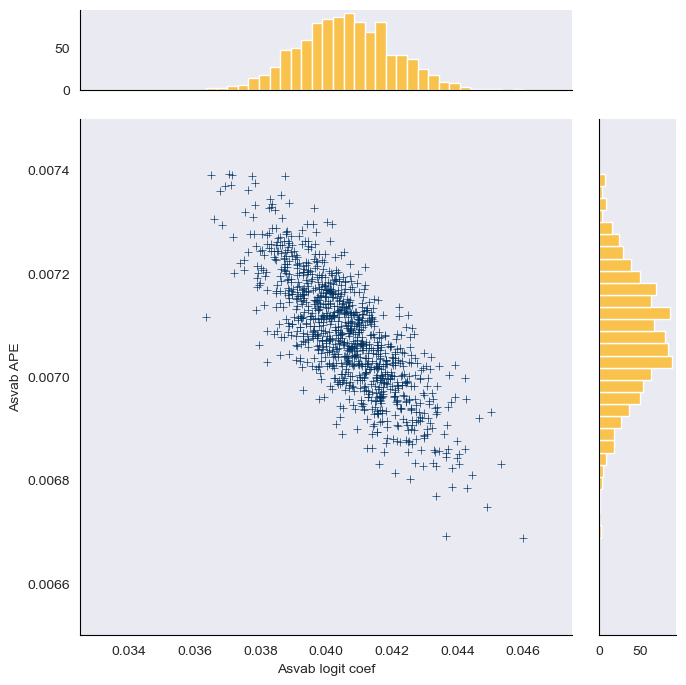

In [267]:
S = 1000                 # Number of bootstrap samples
M = np.empty((S,2))      # Matrix with posterior draws of statistics of interest
N = len(Y)               # Number of observations in dataset

# Compute average partial effect of asvab score using sample-in-hand
Xb = X @ model.coef_.T
ape_hat_asvab = np.mean((np.exp(Xb)/(1+np.exp(Xb))**2)*model.coef_[0,-1])  

print("")
print(f"Logit estimate of the average partial effect of 1 asvab percentile: {ape_hat_asvab:.4f}")

# Perform s=1,...,S bootstrap simulations    
for s in range (0,S):
    bth_sample = nlsy97.sample(n=N, replace=True)  # Take bth bootstrap sample
    X = bth_sample[['intercept', 'female', 'black', 'hispanic', 'asvab']]
    Y = bth_sample['college']
    model_b = LogisticRegression(solver='newton-cg', penalty=None, fit_intercept=False).fit(X,Y)
    M[s,0] = model_b.coef_[0,-1]  
    Xb = X @ model_b.coef_.T
    M[s,1] = np.mean((np.exp(Xb)/(1+np.exp(Xb))**2)*model.coef_[0,-1])  
    
# Save Efron Bootstrap result in a dataframe
EB=pd.DataFrame({'Asvab logit coef':M[:,0], 'Asvab APE':M[:,1]})

print("")
print(EB.quantile([.025, .975]))

# Construct percentile and reverse percentile confidence intervals
lower_bnd = EB.quantile([.025, .975]).iloc[(0,1)]
upper_bnd = EB.quantile([.025, .975]).iloc[(1,1)]
print("")
print(f'A basic percentile boostrap confidence interval for asvab APE is: {lower_bnd:.4f} to {upper_bnd:.4f}')

lower_bnd = 2*ape_hat_asvab - EB.quantile([.025, .975]).iloc[(1,1)]
upper_bnd = 2*ape_hat_asvab - EB.quantile([.025, .975]).iloc[(0,1)]
print("")
print(f'A reverse percentile boostrap confidence interval for asvab APE is: {lower_bnd:.4f} to {upper_bnd:.4f}')

# Scatter (use seaborn add-on to matplotlib)
sns.set_style("dark", {'axes.linewidth': 2, 'axes.edgecolor':'black'})
sns.jointplot(x="Asvab logit coef",y="Asvab APE", data=EB, kind="scatter", \
              height=7, space=0.35, color="#003262", xlim=(0.0325,0.0475), ylim=(0.0065,0.0075), marker='+',
              marginal_ticks=True, marginal_kws=dict(bins=30, fill=True, color='#FDB515', linewidth=1))

# Save the figure
plt.savefig(graphics + 'Figure_Reverse Percentile_Bootstrap_Asvab_APE.png', dpi=300, bbox_inches='tight')
plt.show()    

### Part IV: Assessing `balance'

In [268]:
X = nlsy97[['intercept', 'female', 'black', 'hispanic', 'asvab']]
Y = nlsy97['college']

model = LogisticRegression(solver='newton-cg', penalty=None, fit_intercept=False).fit(X,Y)
model.coef_

nlsy97['pscore'] = model.predict_proba(X)[:,1] # col 0 gives Pr(Y=0|X),  col 1 gives Pr(Y=1|X)
ps_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = ['ps_D01', 'ps_D02', 'ps_D03','ps_D04','ps_D05','ps_D06','ps_D07','ps_D08','ps_D09','ps_D10']
nlsy97['ps_level'] = pd.cut(nlsy97['pscore'], bins=ps_bins, labels=labels, right=False)

In [270]:
pd.crosstab(nlsy97['college'], nlsy97['ps_level'], normalize=True, margins=True)

ps_level,ps_D01,ps_D02,ps_D03,ps_D04,ps_D05,ps_D06,ps_D07,ps_D08,ps_D09,All
college,,,,,,,,,,
0,0.148258,0.175574,0.099565,0.069477,0.057799,0.045724,0.036421,0.019794,0.001584,0.654196
1,0.010293,0.032858,0.035629,0.035629,0.041568,0.054632,0.068488,0.060768,0.005938,0.345804
All,0.158551,0.208432,0.135194,0.105107,0.099367,0.100356,0.104909,0.080562,0.007522,1.000000


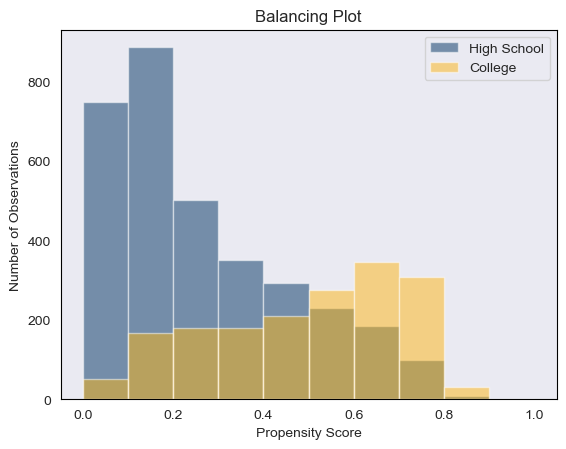

In [253]:
# Create propensity score balance figure
fig, ax = plt.subplots()

# Plot the histograms
ax.hist(nlsy97['pscore'].loc[(nlsy97['college'] == 0)], bins=ps_bins, alpha=0.5, label='High School', color='#003262')
ax.hist(nlsy97['pscore'].loc[(nlsy97['college'] == 1)], bins=ps_bins, alpha=0.5, label='College', color='#FDB515')

# Add labels and title
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Number of Observations')
ax.set_title('Balancing Plot')

# Add legend
ax.legend()

# Show the plot
plt.show()